
## Compiling Data For Model Training

#### Bernard Chang
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

This file explains the workflow used to compile the data from numerous data files available on Kaggle and calculate some additional features. The new data features are then printed to a csv file in the working directory. 

More features, including box score statistics and advanced statistics will be added to this workflow in the future. This workflow was inspired by Susheel Patel's workflow on Kaggle.

### Import Packages

In [1]:
# System packages
import os
import re  # Regular expressions

# Data structures, IO, and matrix manipulation packages
import pandas as pd
import numpy as np


# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns

# ML Packages
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score




### Functions

In [2]:
####################################################################
# A function for dataframe rollups
# Dataframe rollups are 
# This function is from Susheel Patel
# https://www.kaggle.com/susheelpatel/m-ncaa-first-simple-submission
####################################################################

def rollup_df(base_df,rollup_cols,aggregation):
    temp = base_df.groupby(rollup_cols).agg(aggregation)
    temp = temp.reset_index()
    return temp


####################################################################
# A function to remove the region designation from tournament seeding
# The function uses regular expressions to identify and remove the region
# from the seeding label.
# This function is from Susheel Patel
# https://www.kaggle.com/susheelpatel/m-ncaa-first-simple-submission
####################################################################

def clean_seed(seed):
    return int(re.sub("[^0-9]","",seed))


### Load Data

The following workflow uses data that is openly available for the "March Machine Learning Mania 2021 - NCAAM" competition on [kaggle.com](https://www.kaggle.com/c/ncaam-march-mania-2021/data). Details of the datasets are contained in the "Data" landing page. The features I will use are summarized below. 

The dataset is split into two "stages." Stage 1 contains NCAA Men's Basketball data from 1985-2020 and Stage 2 contains the same sets of data for the 2021 season. For the first iteration of this workflow, we will establish a baseline model prediction using the win-loss and margin of victory/loss for each tournament team. For the baseline model, I will fit a logistic regression model to find the likelihood of a team winning its tournament matchup. The next draft will include more comprehensive feature selection and model training with more complex input features.

The datasets we will use for this draft iteration include:

* *MTeams.csv*: Include team IDs and the years they played in their first tournament

* *MSeasons.csv*: Year-by-year historical date information for the tournaments, including the dates the tournmanet starts, and the regions of the tournament in a given year
* *MNCAATourneyCompactResults.csv*: Game-by-game tournament results for all seasons. Includes the round a game was played (based on DayNum), winning/losing team, and final scores
* *MNCAATourneySeeds.csv*: Identifies the seeds for all teams in the tournament, for all seasons.
* *MRegularSeasonCompactResults.csv*: Game-by-game regular season results for all seasons starting in 1985. Contains the date the game was played (based on DayNum), winning/losing teams,  final scores, relative location of the winning team (home, away, neutral site), and number of overtime periods played.

The features used in the first iteration of this workflow are as follows:


* ```Tournament Seeds``` - Tournment seeding for each team, for each year, as determined by the NCAA tournament selection committee; unitless
* ```Winning score``` - Average number of points scored in a win ; points
* ```Losing score``` - Average number of points scored in a  loss ; points
* ```Win ratio``` - Number of games won / Total number of games played ; fraction
* ```Score Gap``` - Cumulative margin of victory - Cumulative margin of loss, normalized by total number of games played; points/game
* ```Score Gap Differential``` - Difference in score gap between the two teams in the tournament matchup ; points/game
* ```Win Ratio Differential``` - Difference in win ratio between the two teams in the tournament matchup ; fraction







In [3]:
repo_data_path = 'https://raw.githubusercontent.com/BC-Chang/predict-march-madness/master/draft1_data'


teams_df = pd.read_csv(f'{repo_data_path}/MTeams.csv')
seasons_df = pd.read_csv(f'{repo_data_path}/MSeasons.csv')
tourney_df = pd.read_csv(f'{repo_data_path}/MNCAATourneyCompactResults.csv')
seeds_df = pd.read_csv(f'{repo_data_path}/MNCAATourneySeeds.csv')
reg_season_df = pd.read_csv(f'{repo_data_path}/MRegularSeasonCompactResults.csv')

datasets = {
    'teams': teams_df,
    'seasons': seasons_df,
    'tourney': tourney_df,
    'seeds': seeds_df,
    'reg_season': reg_season_df
}

### Regular Season Data Compilation

Because we have a large amount of data scattered across multiple dataframes, we need to compile them first and calculate the proposed features before we can move on to training our model.

#### Raw data descriptions and summary statistics

In this step, we check for the completeness of the dataset. Because of the large amount of data available, we can afford to perform list-wise deletion if any data is missing.

In [4]:
# Display first five rows of each dataset, to show 
for key in datasets:
    print(key, '\n')
    print(datasets[key].head())
    print('\n\n')

teams 

   TeamID     TeamName  FirstD1Season  LastD1Season
0    1101  Abilene Chr           2014          2021
1    1102    Air Force           1985          2021
2    1103        Akron           1985          2021
3    1104      Alabama           1985          2021
4    1105  Alabama A&M           2000          2021



seasons 

   Season     DayZero RegionW    RegionX    RegionY    RegionZ
0    1985  10/29/1984    East       West    Midwest  Southeast
1    1986  10/28/1985    East    Midwest  Southeast       West
2    1987  10/27/1986    East  Southeast    Midwest       West
3    1988   11/2/1987    East    Midwest  Southeast       West
4    1989  10/31/1988    East       West    Midwest  Southeast



tourney 

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0
2    1985     136     1207      68     1250      43    N      0
3    1985     136   

#### Describe the data
The following cell displays the summary statistics for each dataset file. We compare the counts of each column to ensure the data is complete and we do not need to perform list-wise deletion. 

The calculated statistics are mostly useless in this case because we have mainly categorical data, particularly for the teams, seasons, and seeds datasets. However, they will become useful when we expand our model to include advanced statistics as features.

In [5]:
for key in datasets:
    print(key, '\n')
    print(datasets[key].describe(), '\n\n')
    

teams 

            TeamID  FirstD1Season  LastD1Season
count   371.000000     371.000000    371.000000
mean   1286.000000    1988.797844   2020.061995
std     107.242715       8.304320      5.046158
min    1101.000000    1985.000000   1985.000000
25%    1193.500000    1985.000000   2021.000000
50%    1286.000000    1985.000000   2021.000000
75%    1378.500000    1985.000000   2021.000000
max    1471.000000    2021.000000   2021.000000 


seasons 

            Season
count    37.000000
mean   2003.000000
std      10.824355
min    1985.000000
25%    1994.000000
50%    2003.000000
75%    2012.000000
max    2021.000000 


tourney 

            Season       DayNum      WTeamID       WScore      LTeamID  \
count  2251.000000  2251.000000  2251.000000  2251.000000  2251.000000   
mean   2002.223456   139.139049  1286.989782    76.936028  1292.128387   
std      10.139617     4.211069   100.701457    11.850828   103.282818   
min    1985.000000   134.000000  1104.000000    43.000000  1101.000

#### Create a dataframe to add desired features
Because the data is scatter across multiple dataframes, and I plan to calculate and add more features (such as advanced statistics) in the future, I create a separate base dataframe of predictor features from which the model will try to train.

In [6]:
unique_teams = teams_df['TeamID'].unique() 
unique_seeds = seeds_df['Seed'].unique() 
years = tourney_df['Season'].unique()

print(f"Number of unique teams = {len(unique_teams)}")
print(f"Number of unique seeds = {len(unique_seeds)}")
print(f"Years contained in this dataset: {min(years)} to {max(years)}")

Number of unique teams = 371
Number of unique seeds = 90
Years contained in this dataset: 1985 to 2019


#### Manual computation of predictor features
Here we use the regular season results dataset (```reg_season_df```) to compute some predictor features

These features were used for the starting point in [Susheel Patel's Kaggle Competition submission](https://www.kaggle.com/susheelpatel/m-ncaa-first-simple-submission) and include the average point differential (```mean_PD```) and win-loss ratios (```WL```)

In [7]:
reg_season_df['mean_PD'] = reg_season_df['WScore'] - reg_season_df['LScore']

# Compile each teams' statistics when they win. Includes number of wins, average number of points scored in a win, 
# and average margin of victory
wins_df = rollup_df(reg_season_df, ['Season', 'WTeamID'], {'DayNum':'count','WScore':'mean','mean_PD':'mean'})

# Compile each teams' statistics when they lose. Includes number of losses, average number of points scored in a loss, 
# and average margin of loss
losses_df = rollup_df(reg_season_df, ['Season', 'LTeamID'], {'DayNum':'count','LScore':'mean','mean_PD':'mean'})

# Rename the columns to be more descriptive
wins_df = wins_df.rename(columns = {'WTeamID':'TeamID', 'DayNum':'W', 'WScore': 'mean_WScore', 'mean_PD':'mean_victory_margin'})
losses_df = losses_df.rename(columns = {'LTeamID':'TeamID', 'DayNum':'L', 'LScore': 'mean_LScore', 'mean_PD':'mean_loss_margin'})

We started off with data scattered across several files and we compiled the team's statistics (and our predictor features) into 2 dataframes. In the following cell, we merge the teams' win and loss statistics into a single dataframe.

Other computed features in the future can be appended to this dataframe, with the intention to be used for training.

In [8]:
# Append teams and seasons of wins_df and losses_df and drop duplicates to get all combinations of seasons and teams
merged_df = wins_df[['Season','TeamID']].append(losses_df[['Season','TeamID']])
merged_df = merged_df.drop_duplicates().reset_index().drop(['index'],axis = 1)

# Merge statistics of the two dataframes. Set NaNs to 0.
feature_df_tmp = pd.merge(merged_df, wins_df, on=['Season','TeamID'], how='left')
season_feature_df = pd.merge(feature_df_tmp, losses_df, on=['Season','TeamID'], how='left')
season_feature_df = season_feature_df.fillna(0)

season_feature_df.head()

,Season,TeamID,W,mean_WScore,mean_victory_margin,L,mean_LScore,mean_loss_margin
0,1985,1102,5.0,71.000000,10.000000,19.0,61.000000,9.947368
1,1985,1103,9.0,70.222222,7.555556,14.0,55.142857,9.857143
2,1985,1104,21.0,72.095238,13.190476,9.0,60.111111,4.777778
3,1985,1106,10.0,75.100000,9.500000,14.0,69.142857,13.285714
4,1985,1108,19.0,85.842105,13.842105,6.0,74.000000,10.666667


Here I find the summary statistics of a team's performance when they win.

In [9]:
print('Team Winning Statistics')
season_feature_df.iloc[:,2:5].describe()

Team Winning Statistics


,W,mean_WScore,mean_victory_margin
count,11594.000000,11594.000000,11594.000000
mean,14.393652,76.186558,11.218139
std,6.073115,6.972282,3.600354
min,0.000000,0.000000,0.000000
25%,10.000000,72.000000,8.800000
50%,14.000000,75.961538,10.941176
75%,19.000000,80.111111,13.359286
max,34.000000,126.347826,28.933333


Here I find the summary statistics of a team's performance when they lose. When compared to the team win statistics, we initially see that the number of wins/losses and their mean margins of victory and loss are comparable. This makes sense because of the binary nature of win/loss data.

We see that the mean number of points a team scores in a win is generally larger than that when they lose. This makes intuitive sense.

In [10]:
print('Team Losing Statistics')
season_feature_df.iloc[:,5:].describe()

Team Losing Statistics


,L,mean_LScore,mean_loss_margin
count,11594.000000,11594.000000,11594.000000
mean,14.393652,65.204899,11.446697
std,5.133291,6.070216,3.379325
min,0.000000,0.000000,0.000000
25%,11.000000,61.176471,9.125000
50%,14.000000,64.875000,11.200000
75%,18.000000,68.818182,13.473684
max,31.000000,117.800000,35.076923


As proposed by Susheel Patel and @theoviel on Kaggle, we compute the win-loss ratio for each team and the overall point differential.

In [11]:
season_feature_df['WL'] = season_feature_df['W'] / (season_feature_df['W'] + season_feature_df['L'])

season_feature_df['Win_Diff'] = season_feature_df['mean_WScore'] * season_feature_df['W']
season_feature_df['Loss_Diff'] = season_feature_df['mean_LScore'] * season_feature_df['L']

season_feature_df['Point_Diff'] = season_feature_df['Win_Diff'] - season_feature_df['Loss_Diff']
# Normalize the point differential by number of games played
season_feature_df['Point_Diff'] = season_feature_df['Point_Diff'] / (season_feature_df['W'] + season_feature_df['L'])
season_feature_df.head()

,Season,TeamID,W,mean_WScore,mean_victory_margin,L,mean_LScore,mean_loss_margin,WL,Win_Diff,Loss_Diff,Point_Diff
0,1985,1102,5.0,71.000000,10.000000,19.0,61.000000,9.947368,0.208333,355.0,1159.0,-33.500000
1,1985,1103,9.0,70.222222,7.555556,14.0,55.142857,9.857143,0.391304,632.0,772.0,-6.086957
2,1985,1104,21.0,72.095238,13.190476,9.0,60.111111,4.777778,0.700000,1514.0,541.0,32.433333
3,1985,1106,10.0,75.100000,9.500000,14.0,69.142857,13.285714,0.416667,751.0,968.0,-9.041667
4,1985,1108,19.0,85.842105,13.842105,6.0,74.000000,10.666667,0.760000,1631.0,444.0,47.480000


I only want to keep the average score in a win/loss (```mean_WScore```, ```mean_LScore```), win ratio (```WL```), and Point differential (```Point_Diff```) because information about all other features in the dataframe so far are contained in these features

In [12]:
try:
    season_feature_df = season_feature_df.drop(['W', 'L', 'mean_victory_margin', 'mean_loss_margin', 'Win_Diff', 'Loss_Diff'], axis=1)
except:
    pass
season_feature_df.head()

,Season,TeamID,mean_WScore,mean_LScore,WL,Point_Diff
0,1985,1102,71.000000,61.000000,0.208333,-33.500000
1,1985,1103,70.222222,55.142857,0.391304,-6.086957
2,1985,1104,72.095238,60.111111,0.700000,32.433333
3,1985,1106,75.100000,69.142857,0.416667,-9.041667
4,1985,1108,85.842105,74.000000,0.760000,47.480000


### Feature Visualization

Here I visualize the features calculated above. 

First, I visualize the mean number of points a team scores in a win versus a loss. Both features are roughly normally distributed, with around the same standard deviations (as described in previous cells). The expected mean number of points a team scores in a win is larger than that in a loss. This is the behavior we would expect.

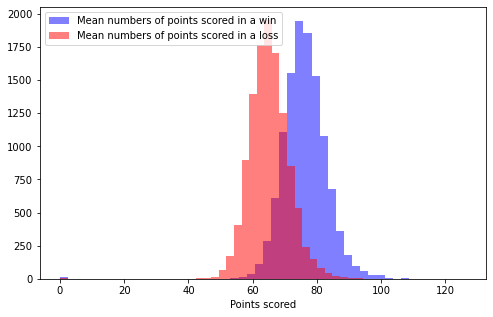

In [13]:
plt.figure(figsize=(8,5))
plt.hist(season_feature_df['mean_WScore'], bins=50, alpha=0.5, color='b', label='Mean numbers of points scored in a win')
plt.hist(season_feature_df['mean_LScore'], bins=50, alpha=0.5, color='r', label='Mean numbers of points scored in a loss')
plt.xlabel('Points scored')
plt.legend()

Next, I visualize the point differential and its correlation with win/loss ratio. From the scatter plot, we see that the win-loss ratio monotonically increases with the team's total point differential, confirming the intuitive belief that scoring more points while giving up fewer (i.e. good offense and defense) leads to more wins. 

Text(0.5, 0, 'Point Differential')

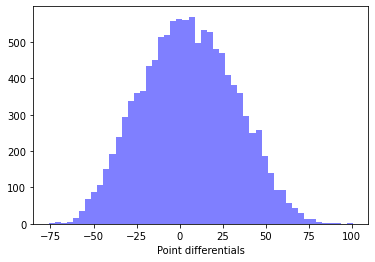

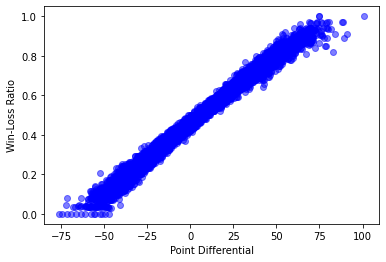

In [14]:
plt.figure()
plt.hist(season_feature_df['Point_Diff'],  bins=50, alpha=0.5, color='b')
# plt.hist(season_feature_df['mean_loss_margin'], bins=50, alpha=0.5, color='r', label='Mean margins of loss')
plt.xlabel('Point differentials')

plt.figure()
plt.plot(season_feature_df['Point_Diff'],season_feature_df['WL'], 'ob', alpha=0.5)
plt.ylabel('Win-Loss Ratio')
plt.xlabel('Point Differential')

### NCAA Tournament Data Compilation

Next, we need to compute and compile the same set of features for each matchup in the NCAA tournament historical data.

In [15]:
# First we drop the features we don't need from the tournament results dataframe. 
# This includes location the team wins in and the number of overtimes played
tourney_results = tourney_df.copy()
tourney_results = tourney_results.drop(columns = ['WLoc', 'NumOT'], axis=1)

Merge the NCAA tournament results with the tournament seeding dataframe

In [16]:
# Merge the winning seeds
tourney_results = pd.merge(tourney_results, seeds_df, how='left', left_on=['Season', 'WTeamID'], right_on=['Season','TeamID'])

# Drop the TeamID Column
tourney_results = tourney_results.drop(columns=['TeamID'], axis=1)

# Rename the seed column to designate as winning seed
tourney_results = tourney_results.rename(columns={'Seed':'Win_Seed'})

# Merge the losing seeds
tourney_results= pd.merge(tourney_results, seeds_df, how='left', left_on=['Season', 'LTeamID'], right_on=['Season','TeamID'])

# Drop the TeamID Column
tourney_results = tourney_results.drop(columns=['TeamID'], axis=1)

# Rename the seed column to designate as losing seed
tourney_results = tourney_results.rename(columns={'Seed':'Lose_Seed'})

tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Win_Seed,Lose_Seed
0,1985,136,1116,63,1234,54,X09,X08
1,1985,136,1120,59,1345,58,Z11,Z06
2,1985,136,1207,68,1250,43,W01,W16
3,1985,136,1229,58,1425,55,Y09,Y08
4,1985,136,1242,49,1325,38,Z03,Z14


Remove the region designation from ```Win_Seed``` and ```Lose_Seed```

In [17]:
tourney_results['Win_Seed'] = tourney_results['Win_Seed'].apply(clean_seed)
tourney_results['Lose_Seed'] = tourney_results['Lose_Seed'].apply(clean_seed)
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Win_Seed,Lose_Seed
0,1985,136,1116,63,1234,54,9,8
1,1985,136,1120,59,1345,58,11,6
2,1985,136,1207,68,1250,43,1,16
3,1985,136,1229,58,1425,55,9,8
4,1985,136,1242,49,1325,38,3,14


Here I plot the histograms of the winning and losing seeds. As expected, we see that most wins come from higher seeds (1-seed is the highest seed). Interestingly, the losing seed is relatively evenly distributed across all seeds. This can be explained by the fact that the tournament can only have one winner. So the most number of tournments have been won by higher seeded teams. 

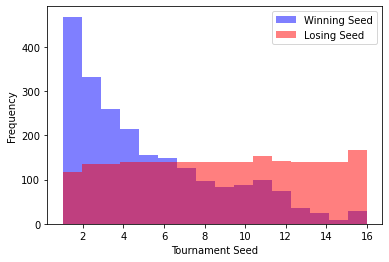

In [18]:
# plt.plot(tourney_results['DayNum'], tourney_results['Win_Seed'], 'o')
plt.hist(tourney_results['Win_Seed'], bins=16, color='b', alpha=0.5, label='Winning Seed')
plt.hist(tourney_results['Lose_Seed'], bins=16, color='r', alpha=0.5, label='Losing Seed')
plt.xlabel('Tournament Seed')
plt.ylabel('Frequency')
plt.legend()

Merge the regular season results with the tournament results starting with team win statistics

In [19]:
final_features = pd.merge(tourney_results, season_feature_df, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
final_features = final_features.rename(columns={'mean_WScore':'mean_WScore_W',
                                               'mean_LScore':'mean_LScore_W',
                                               'WL':'WL_W',
                                               'Point_Diff':'Point_Diff_W'})

final_features = final_features.drop(['TeamID'], axis=1)

In [20]:
final_features.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Win_Seed,Lose_Seed,mean_WScore_W,mean_LScore_W,WL_W,Point_Diff_W
0,1985,136,1116,63,1234,54,9,8,68.952381,59.000000,0.636364,22.424242
1,1985,136,1120,59,1345,58,11,6,72.666667,66.545455,0.620690,19.862069
2,1985,136,1207,68,1250,43,1,16,76.680000,64.000000,0.925926,66.259259
3,1985,136,1229,58,1425,55,9,8,74.200000,64.142857,0.740741,38.333333
4,1985,136,1242,49,1325,38,3,14,78.652174,67.428571,0.766667,44.566667


In [21]:
final_features = pd.merge(final_features, season_feature_df, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
final_features = final_features.rename(columns={'mean_WScore':'mean_WScore_L',
                                               'mean_LScore':'mean_LScore_L',
                                               'WL':'WL_L',
                                               'Point_Diff':'Point_Diff_L'})

final_features = final_features.drop(['TeamID'], axis=1)


In [22]:
final_features.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Win_Seed,Lose_Seed,mean_WScore_W,mean_LScore_W,WL_W,Point_Diff_W,mean_WScore_L,mean_LScore_L,WL_L,Point_Diff_L
0,1985,136,1116,63,1234,54,9,8,68.952381,59.000000,0.636364,22.424242,76.250000,56.700000,0.666667,31.933333
1,1985,136,1120,59,1345,58,11,6,72.666667,66.545455,0.620690,19.862069,70.058824,67.125000,0.680000,26.160000
2,1985,136,1207,68,1250,43,1,16,76.680000,64.000000,0.925926,66.259259,74.727273,60.277778,0.379310,-9.068966
3,1985,136,1229,58,1425,55,9,8,74.200000,64.142857,0.740741,38.333333,72.947368,58.777778,0.678571,30.607143
4,1985,136,1242,49,1325,38,3,14,78.652174,67.428571,0.766667,44.566667,67.450000,67.857143,0.740741,32.370370


In [23]:
# Rename winning team identifiers as A and losing as B
winners_df_cols = {'WTeamID':'Team_A',
              'WScore':'Score_A',
              'LTeamID':'Team_B',
              'LScore':'Score_B',
              'Win_Seed':'Seed_A',
              'Lose_Seed':'Seed_B',
              'mean_WScore_W':'mean_WScore_A',
              'mean_LScore_W':'mean_LScore_A',
              'WL_W':'WL_A',
              'Point_Diff_W':'Point_Diff_A',
              'mean_WScore_L':'mean_WScore_B',
              'mean_LScore_L':'mean_LScore_B',
              'WL_L':'WL_B',
              'Point_Diff_L':'Point_Diff_B'}

# Rename losing team identifiers as A and winning as B
losers_df_cols = {'WTeamID':'Team_B',
              'WScore':'Score_B',
              'LTeamID':'Team_A',
              'LScore':'Score_A',
              'Win_Seed':'Seed_B',
              'Lose_Seed':'Seed_A',
              'mean_WScore_W':'mean_WScore_B',
              'mean_LScore_W':'mean_LScore_B',
              'WL_W':'WL_B',
              'Point_Diff_W':'Point_Diff_B',
              'mean_WScore_L':'mean_WScore_A',
              'mean_LScore_L':'mean_LScore_A',
              'WL_L':'WL_A',
              'Point_Diff_L':'Point_Diff_A'}

In [24]:
winners_df = final_features.copy()
winners_df = winners_df.rename(columns=winners_df_cols)

losers_df = final_features.copy()
losers_df = losers_df.rename(columns=losers_df_cols)

predictor_features = pd.concat([winners_df, losers_df], axis=0).reset_index().drop(columns=['index'])

predictor_features['Win_A'] = predictor_features.apply(lambda x: 1 if x['Score_A'] > x['Score_B'] else 0, axis=1)

In [25]:
predictor_features

,Season,DayNum,Team_A,Score_A,Team_B,Score_B,Seed_A,Seed_B,mean_WScore_A,mean_LScore_A,WL_A,Point_Diff_A,mean_WScore_B,mean_LScore_B,WL_B,Point_Diff_B,Win_A
0,1985,136,1116,63,1234,54,9,8,68.952381,59.000000,0.636364,22.424242,76.250000,56.700000,0.666667,31.933333,1
1,1985,136,1120,59,1345,58,11,6,72.666667,66.545455,0.620690,19.862069,70.058824,67.125000,0.680000,26.160000,1
2,1985,136,1207,68,1250,43,1,16,76.680000,64.000000,0.925926,66.259259,74.727273,60.277778,0.379310,-9.068966,1
3,1985,136,1229,58,1425,55,9,8,74.200000,64.142857,0.740741,38.333333,72.947368,58.777778,0.678571,30.607143,1
4,1985,136,1242,49,1325,38,3,14,78.652174,67.428571,0.766667,44.566667,67.450000,67.857143,0.740741,32.370370,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,2019,146,1246,71,1120,77,2,5,77.370370,73.833333,0.818182,49.878788,81.800000,70.777778,0.735294,41.411765,0
4498,2019,146,1181,67,1277,68,1,2,84.379310,78.400000,0.852941,60.441176,80.035714,73.166667,0.823529,53.000000,0
4499,2019,152,1277,51,1403,61,2,3,80.035714,73.166667,0.823529,53.000000,75.884615,61.000000,0.812500,50.218750,0
4500,2019,152,1120,62,1438,63,5,1,81.800000,70.777778,0.735294,41.411765,72.379310,66.666667,0.906250,59.343750,0


Compute the differences between Teams A and B

In [31]:
predictor_features['SeedDiff'] = predictor_features['Seed_A'] - predictor_features['Seed_B']

predictor_features['PD_Diff'] = predictor_features['Point_Diff_A'] - predictor_features['Point_Diff_B']

predictor_features['WL_Diff'] = predictor_features['WL_A'] - predictor_features['WL_B']
predictor_features.head()

,Season,DayNum,Team_A,Score_A,Team_B,Score_B,Seed_A,Seed_B,mean_WScore_A,mean_LScore_A,WL_A,Point_Diff_A,mean_WScore_B,mean_LScore_B,WL_B,Point_Diff_B,Win_A,SeedDiff,PD_Diff,WL_Diff
0,1985,136,1116,63,1234,54,9,8,68.952381,59.000000,0.636364,22.424242,76.250000,56.700000,0.666667,31.933333,1,1,-9.509091,-0.030303
1,1985,136,1120,59,1345,58,11,6,72.666667,66.545455,0.620690,19.862069,70.058824,67.125000,0.680000,26.160000,1,5,-6.297931,-0.059310
2,1985,136,1207,68,1250,43,1,16,76.680000,64.000000,0.925926,66.259259,74.727273,60.277778,0.379310,-9.068966,1,-15,75.328225,0.546616
3,1985,136,1229,58,1425,55,9,8,74.200000,64.142857,0.740741,38.333333,72.947368,58.777778,0.678571,30.607143,1,1,7.726190,0.062169
4,1985,136,1242,49,1325,38,3,14,78.652174,67.428571,0.766667,44.566667,67.450000,67.857143,0.740741,32.370370,1,-11,12.196296,0.025926


In [32]:
predictor_features.to_csv('training_dataset.csv', index=False)

#### Build Test Dataset

In [28]:
val_dataset = pd.read_csv(f'{repo_data_path}/MSampleSubmissionStage1.csv')

val_df = val_dataset.copy()

val_df['Season'] = val_df['ID'].apply(lambda x: int(x.split('_')[0])) 


val_df['TeamID_A'] = val_df['ID'].apply(lambda x: int(x.split('_')[1])) 


val_df['TeamID_B'] = val_df['ID'].apply(lambda x: int(x.split('_')[2])) 

val_df = pd.merge(val_df,
                  seeds_df,
                  how = 'left',
                  left_on = ['Season','TeamID_A'],
                  right_on = ['Season','TeamID']
                  ).rename(columns = {'Seed':'Seed_A'}).drop(['TeamID'], axis = 1) 

val_df = pd.merge(val_df,
                  seeds_df,
                  how = 'left',
                  left_on = ['Season','TeamID_B'],
                  right_on = ['Season','TeamID']
                  ).rename(columns = {'Seed':'Seed_B'}).drop(['TeamID'], axis = 1) 

# Clean seeds
val_df['Seed_A'] = val_df['Seed_A'].apply(clean_seed)
val_df['Seed_B'] = val_df['Seed_B'].apply(clean_seed)

val_df['SeedDiff'] = val_df['Seed_A'] - val_df['Seed_B']

# Join season statistics
val_df = pd.merge(val_df,
             season_feature_df,
             how = 'left',
             left_on = ['Season','TeamID_A'],
             right_on = ['Season','TeamID'],
             ).rename(columns = 
                      {'mean_WScore':'mean_WScore_A', 
                       'mean_LScore':'mean_LScore_A',
                       'WL':'WL_A',
                       'Point_Diff':'Point_Diff_A'}
                     ).drop(['TeamID'],axis = 1)

val_df = pd.merge(val_df,
             season_feature_df,
             how = 'left',
             left_on = ['Season','TeamID_B'],
             right_on = ['Season','TeamID'],
             ).rename(columns = 
                      {'mean_WScore':'mean_WScore_B', 
                       'mean_LScore':'mean_LScore_B',
                       'WL':'WL_B',
                       'Point_Diff':'Point_Diff_B'}
                     ).drop(['TeamID'],axis = 1)

val_df['SeedDiff'] = val_df['Seed_A'] - val_df['Seed_B']

val_df['PD_Diff'] = val_df['Point_Diff_A'] - val_df['Point_Diff_B']

val_df['WL_Diff'] = val_df['WL_A'] - val_df['WL_B']

In [29]:
val_df.describe()

,Pred,Season,TeamID_A,TeamID_B,Seed_A,Seed_B,SeedDiff,mean_WScore_A,mean_LScore_A,WL_A,Point_Diff_A,mean_WScore_B,mean_LScore_B,WL_B,Point_Diff_B,PD_Diff,WL_Diff
count,11390.0,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000
mean,0.5,2017.000000,1236.486128,1358.525637,8.826602,8.761633,0.064969,78.881415,67.393530,0.719949,37.980492,78.017534,66.605283,0.724189,38.124145,-0.143653,-0.004240
std,0.0,1.414276,88.035207,82.661731,4.738361,4.588366,6.644729,5.110269,6.829468,0.100851,15.290823,5.265736,6.412328,0.102011,15.287520,21.681920,0.143937
min,0.5,2015.000000,1101.000000,1112.000000,1.000000,1.000000,-15.000000,64.280000,0.000000,0.424242,-5.454545,64.280000,0.000000,0.424242,-5.454545,-70.790553,-0.515152
25%,0.5,2016.000000,1159.000000,1300.000000,5.000000,5.000000,-5.000000,75.350000,64.250000,0.656250,28.333333,74.157895,62.875000,0.645161,26.129032,-15.230221,-0.104779
50%,0.5,2017.000000,1234.000000,1374.000000,9.000000,9.000000,0.000000,78.800000,67.461538,0.718750,38.030303,77.800000,66.166667,0.727273,38.333333,-0.061553,0.000000
75%,0.5,2018.000000,1300.000000,1433.000000,13.000000,12.000000,5.000000,82.350000,71.000000,0.781250,48.031250,81.791667,70.500000,0.800000,48.687500,14.765029,0.093750
max,0.5,2019.000000,1462.000000,1463.000000,16.000000,16.000000,15.000000,93.833333,84.750000,1.000000,80.272727,93.833333,84.750000,1.000000,80.272727,74.803977,0.469697


In [30]:
val_df.to_csv('validation_dataset.csv', index=False)


I hope this was helpful,

*You name*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
